We'll start with some magic that will make torch play nice with R on Talapas

In [1]:
Sys.setenv(TORCH_HOME='/gpfs/projects/datascience/shared/R/torch/lantern/build/libtorch')
libdir='/gpfs/projects/datascience/shared/R/Data4ML'
.libPaths(libdir)
Sys.setenv(R_LIBS = paste(libdir, Sys.getenv("R_LIBS"), sep=.Platform$path.sep))

# Text Analysis for sequencing

We'll be playing around with the DeePromoter [https://github.com/egochao/DeePromoter](https://github.com/egochao/DeePromoter) dataset. This dataset contains 300bp sequences that bracket known transcription start sites (with the TSS located at position 250 out of 300) from the Eukaryotic Promoter Database (EPDnew). Their goal is to accurately predict sequences that act as promoter sites in eukaryotes for subsequent studies. We'll try a few methods to get a feel for utilizing raw text analysis

1. Feature engineering and Random Forests

2. A Deep Learning Approaching

In both cases, we'll need to create sequences to use non-promoter examples. We'll create random sequences, but there are other ways in the literature.




# Libraries
We'll use Torch for the dep learning and K-mer for  'feature engineering.'  

In [2]:
library("torch")
library('kmer')
library('randomForest')


randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.



# Read in the Sequences File

In [3]:
seq_data<-read.csv("/gpfs/projects/datascience/shared/deePromoter_data/hs_pos_TATA.txt",header=FALSE)

# Data Prep for Structured Features

We want to go from our string of letters to structured features. We'll start with getting kmer couts. The package 'kmer' were working with expect our sequencs as a matrix of characters. This means will need to break our strings apart

In [4]:
head(seq_data)
pos_char<-strsplit(seq_data[,1],"")
head(pos_char)

,V1
,<chr>
1,CTCCACTTTTTCTCACGTTTATCTGAGCGAAAACAAGCACGGTTCGGCAGCCTCCTTTCCCAGCCCTACCTTTGTGCTGCAAAAGCGAAAATTCAAAAGCCAAGTACAATAGGAGACCGCCCACCCTGGCTCCCTCGTGACACGAGGGAGCGCGAAGCGGAGGGCGCCTCGCGGCAGGAGCGGGATTTCCGGGGTCACGGGAACCGGCAGGGGAACGGGATAAAGTTCCCGGAGAAAGGAAAGGAGAGCGTGGGATAGTAAAAGAGAAGACGCGGAGAAGAGGAGAGGACCTACAAGAAC
2,CCAGCAGATGGAAAACAGGACAATGTAACACTGTTCTTATCATCACTATCAGCTGGGACCAGAACAGACACTCAATAAACAGCCTCACACTACAATGAAGCTTGGAGAACAAAGGAGCATCAAAGGGACATGGAGGGCAAGGGTAGCTCTTCTGCTCCCCAATCACATGCACTCCCCGTCTCACCGCAACATCTGTCCCTGAGCCTTCTCCCAGCAGACCTATAAATCCAGGCTGGCTCCTCACTCCCCACACATCTGCTCCTGCTCTCTCTCCTCCAGCGACCCTAGCCATGAGAACCC
3,TCAGAGAAACTGGTCTCTTGATAATAGCCATAGATTACATACTGTGGTCTTCCTCTACATAGACCCTACCTCACCTACCACTCCTGGTCTTAGCTGAAAAACAGGCTAGCCTCGACTCATACTGTCATTTCCTATCCTCCCACTGAAGTGCACTGGCTCAGCAGATTTATTACTCCATAGATTTATTACTCCATTCTATGATTCATCCTCTCTGCTTCCTATAAAAGGCAGAGACAGAGCTTCCAGAGGAGCAGAGGGGCTGAGACCAAACCAGAAACCTCCAATTCTCATGTGGAAGCC
4,GAAAAGGTAAAAATACAAGTATGGCTGTTGTTGCTTCAGCCGGGCCTTAATTACCAGACACAAGAAGCAGTTCAGAAATCTGGTCTCTGTTGTTGTAGAGGTCACCAAATCATTAACATCGTCAATCTGGCAGTAGCTAATTTAAATAGCACCTGATGTTGCAACGCCTCCCTTCGTTTCCCCAGCCAATCAGATCCAGGCTTCGGCTGACAGATGGTCCCATAAATGGATGTAAAAAGGGGAAGCTTCGAGCCAATTTCAGCAAGGCTCTGTTCAGTTGTTCTTATCTACATCCTAGAA
5,CAGGGTCTGCAGAGAGAGAGTGGGGGAGTGCGGGTCGGAGCTTCTGCGCGGACCGGGGCGGGGCACCTCTGGAGGGCAGGGGCCTCTGGTCTCTGGGAGGGGAGGGAATTGACCAATGGGGAGAGAGCCCATATTTGCTCTCAGGAGCCTGCAAATTCCTCAGGGCTCAGATATCCGCCCCTGACACCATTCCTCCCTTCCCCCCTCCACCGGCCGCGGGCATAAAAGGCGCCAGGTGAGGGCCTCGCCGCTCCTCCCGCGAATCGCAGCTTCTGAGACCAGGGTTGCTCCGTCCGTGCT
6,AGAATGAGTGCGTCGGGAACCCCAAAACCCTAGATCAAGATACAAGGGGAGTCGACGGCCCGGAAACCTCGCTGCGGGTGCCCTAAGCGCGAGGCCGCCCGGGCAGGGCCGCCCAGGGACCGGGGCGCTGGGTGCGGGGCACGGGGCTCCACCTCCCGCGGGCTGGGGCGCGCAGCGCGCGGCCCCTTTAAGAAAGTTCGCCGGGCGAGTTCATCAAAGTTTAAAAACTCGCCGTGGAGAAGGGCGCGGGGGAAGAGGAGAGAGGGAGAGCGCTGACCCAGGCGAGAGAGAGGGGAAAGG


[[1]]
  [1] "C" "T" "C" "C" "A" "C" "T" "T" "T" "T" "T" "C" "T" "C" "A" "C" "G" "T"
 [19] "T" "T" "A" "T" "C" "T" "G" "A" "G" "C" "G" "A" "A" "A" "A" "C" "A" "A"
 [37] "G" "C" "A" "C" "G" "G" "T" "T" "C" "G" "G" "C" "A" "G" "C" "C" "T" "C"
 [55] "C" "T" "T" "T" "C" "C" "C" "A" "G" "C" "C" "C" "T" "A" "C" "C" "T" "T"
 [73] "T" "G" "T" "G" "C" "T" "G" "C" "A" "A" "A" "A" "G" "C" "G" "A" "A" "A"
 [91] "A" "T" "T" "C" "A" "A" "A" "A" "G" "C" "C" "A" "A" "G" "T" "A" "C" "A"
[109] "A" "T" "A" "G" "G" "A" "G" "A" "C" "C" "G" "C" "C" "C" "A" "C" "C" "C"
[127] "T" "G" "G" "C" "T" "C" "C" "C" "T" "C" "G" "T" "G" "A" "C" "A" "C" "G"
[145] "A" "G" "G" "G" "A" "G" "C" "G" "C" "G" "A" "A" "G" "C" "G" "G" "A" "G"
[163] "G" "G" "C" "G" "C" "C" "T" "C" "G" "C" "G" "G" "C" "A" "G" "G" "A" "G"
[181] "C" "G" "G" "G" "A" "T" "T" "T" "C" "C" "G" "G" "G" "G" "T" "C" "A" "C"
[199] "G" "G" "G" "A" "A" "C" "C" "G" "G" "C" "A" "G" "G" "G" "G" "A" "A" "C"
[217] "G" "G" "G" "A" "T" "A" "A" "A" "G" "T" "T" "C" "C" "C" "G" "G" "A" "G"
[235] "A" "A" "A" "G" "G" "A" "A" "A" "G" "G" "A" "G" "A" "G" "C" "G" "T" "G"
[253] "G" "G" "A" "T" "A" "G" "T" "A" "A" "A" "A" "G" "A" "G" "A" "A" "G" "A"
[271] "C" "G" "C" "G" "G" "A" "G" "A" "A" "G" "A" "G" "G" "A" "G" "A" "G" "G"
[289] "A" "C" "C" "T" "A" "C" "A" "A" "G" "A" "A" "C"

[[2]]
  [1] "C" "C" "A" "G" "C" "A" "G" "A" "T" "G" "G" "A" "A" "A" "A" "C" "A" "G"
 [19] "G" "A" "C" "A" "A" "T" "G" "T" "A" "A" "C" "A" "C" "T" "G" "T" "T" "C"
 [37] "T" "T" "A" "T" "C" "A" "T" "C" "A" "C" "T" "A" "T" "C" "A" "G" "C" "T"
 [55] "G" "G" "G" "A" "C" "C" "A" "G" "A" "A" "C" "A" "G" "A" "C" "A" "C" "T"
 [73] "C" "A" "A" "T" "A" "A" "A" "C" "A" "G" "C" "C" "T" "C" "A" "C" "A" "C"
 [91] "T" "A" "C" "A" "A" "T" "G" "A" "A" "G" "C" "T" "T" "G" "G" "A" "G" "A"
[109] "A" "C" "A" "A" "A" "G" "G" "A" "G" "C" "A" "T" "C" "A" "A" "A" "G" "G"
[127] "G" "A" "C" "A" "T" "G" "G" "A" "G" "G" "G" "C" "A" "A" "G" "G" "G" "T"
[145] "A" "G" "C" "T" "C" "T" "T" "C" "T" "G" "C" "T" "C" "C" "C" "C" "A" "A"
[163] "T" "C" "A" "C" "A" "T" "G" "C" "A" "C" "T" "C" "C" "C" "C" "G" "T" "C"
[181] "T" "C" "A" "C" "C" "G" "C" "A" "A" "C" "A" "T" "C" "T" "G" "T" "C" "C"
[199] "C" "T" "G" "A" "G" "C" "C" "T" "T" "C" "T" "C" "C" "C" "A" "G" "C" "A"
[217] "G" "A" "C" "C" "T" "A" "T" "A" "A" "A" "T" "C" "C" "A" "G" "G" "C" "T"
[235] "G" "G" "C" "T" "C" "C" "T" "C" "A" "C" "T" "C" "C" "C" "C" "A" "C" "A"
[253] "C" "A" "T" "C" "T" "G" "C" "T" "C" "C" "T" "G" "C" "T" "C" "T" "C" "T"
[271] "C" "T" "C" "C" "T" "C" "C" "A" "G" "C" "G" "A" "C" "C" "C" "T" "A" "G"
[289] "C" "C" "A" "T" "G" "A" "G" "A" "A" "C" "C" "C"

[[3]]
  [1] "T" "C" "A" "G" "A" "G" "A" "A" "A" "C" "T" "G" "G" "T" "C" "T" "C" "T"
 [19] "T" "G" "A" "T" "A" "A" "T" "A" "G" "C" "C" "A" "T" "A" "G" "A" "T" "T"
 [37] "A" "C" "A" "T" "A" "C" "T" "G" "T" "G" "G" "T" "C" "T" "T" "C" "C" "T"
 [55] "C" "T" "A" "C" "A" "T" "A" "G" "A" "C" "C" "C" "T" "A" "C" "C" "T" "C"
 [73] "A" "C" "C" "T" "A" "C" "C" "A" "C" "T" "C" "C" "T" "G" "G" "T" "C" "T"
 [91] "T" "A" "G" "C" "T" "G" "A" "A" "A" "A" "A" "C" "A" "G" "G" "C" "T" "A"
[109] "G" "C" "C" "T" "C" "G" "A" "C" "T" "C" "A" "T" "A" "C" "T" "G" "T" "C"
[127] "A" "T" "T" "T" "C" "C" "T" "A" "T" "C" "C" "T" "C" "C" "C" "A" "C" "T"
[145] "G" "A" "A" "G" "T" "G" "C" "A" "C" "T" "G" "G" "C" "T" "C" "A" "G" "C"
[163] "A" "G" "A" "T" "T" "T" "A" "T" "T" "A" "C" "T" "C" "C" "A" "T" "A" "G"
[181] "A" "T" "T" "T" "A" "T" "T" "A" "C" "T" "C" "C" "A" "T" "T" "C" "T" "A"
[199] "T" "G" "A" "T" "T" "C" "A" "T" "C" "C" "T" "C" "T" "C" "T" "G" "C" "T"
[217] "T" "C" "C" "T" "A" "T" "A" "A" "A" "A" "G" "G" "C" "A" "G" "A" "G" "A"
[235] "C" "A" "G" "A" "G" "C" "T" "T" "C" "C" "A" "G" "A" "G" "G" "A" "G" "C"
[253] "A" "G" "A" "G" "G" "G" "G" "C" "T" "G" "A" "G" "A" "C" "C" "A" "A" "A"
[271] "C" "C" "A" "G" "A" "A" "A" "C" "C" "T" "C" "C" "A" "A" "T" "T" "C" "T"
[289] "C" "A" "T" "G" "T" "G" "G" "A" "A" "G" "C" "C"

[[4]]
  [1] "G" "A" "A" "A" "A" "G" "G" "T" "A" "A" "A" "A" "A" "T" "A" "

Next were going to use the R command 
```R
sample
```
we'll use this to generate two kinds of non-promoter sequences
1. A random shuffle of our promoter sequences
2. Truly random sequences of As, Ts, Gs, and Cs


In [5]:

n_neg=nrow(seq_data)
neg_char=c()

for( i in 1:n_neg){
    pos_sample=sample(length(pos_char),1)
    neg_sample=sample(pos_char[[pos_sample]],length(pos_char[[pos_sample]]))    
    neg_char=rbind(neg_char,neg_sample)
                   }  

rand_char=c()
for( i in 1:n_neg){
    r_sample=sample(c('A','T','G','C'),300,replace=T)
    rand_char<-rbind(rand_char,r_sample)
    }




Now we'll create our kmer counts, combine our data and add labels

In [6]:
#Create Kmers
pos=data.frame(kcount(pos_char,k=4))
neg=data.frame(kcount(neg_char,k=4))
rand=data.frame(kcount(rand_char,k=4))


#Combine and add a Label
dataset=rbind(pos,neg,rand)
dataset$y <- c(rep(1,nrow(pos)),rep(0,nrow(neg)+nrow(rand)))

head(dataset)

# Remember from before we'll want to split the dataset into Train and Testing sets

In [7]:
# Randomly Select training indices
train_index <- sample(seq_len(nrow(dataset)),size= nrow(dataset)*.8, replace=FALSE )

#Split the data
train <- dataset[train_index,]
test <- dataset[-train_index,]


x<-subset(train, select=-y)
y<-as.factor(train$y)

xtest<-subset(test, select=-y)
ytest<-as.factor(test$y)


# Fit a random forest

just like last time we can use a random forest and importance to learning what kmers might be useful for predicting promoters.

In [8]:
rf=randomForest(x,y,xtest,ytest,ntree=100,importance=TRUE,keep.forest=TRUE)



Call:
 randomForest(x = x, y = y, xtest = xtest, ytest = ytest, ntree = 100,      importance = TRUE, keep.forest = TRUE) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 16

        OOB estimate of  error rate: 5.49%
Confusion matrix:
     0    1 class.error
0 4633   62  0.01320554
1  324 2010  0.13881748
                Test set error rate: 4.95%
Confusion matrix:
     0   1 class.error
0 1157   6 0.005159071
1   81 514 0.136134454


,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
AAAA,7.8987796,4.42451549,8.59262262,13.567132
AAAC,1.5639601,0.88399742,1.97340039,3.298338
AAAG,6.7891922,2.11944823,7.54981330,12.057227
AAAT,4.8191995,1.40542598,4.92233707,4.842698
AACA,0.8349536,2.48636071,2.10182877,2.892091
AACC,0.2273212,1.30330780,1.12560461,3.441432
AACG,3.6947478,7.13482056,7.61155717,30.339822
AACT,0.6389042,1.24326136,1.19707352,2.970555
AAGA,2.2564414,0.96623698,2.46819732,4.787076
AAGC,2.0941208,0.66889743,2.08976059,3.561945


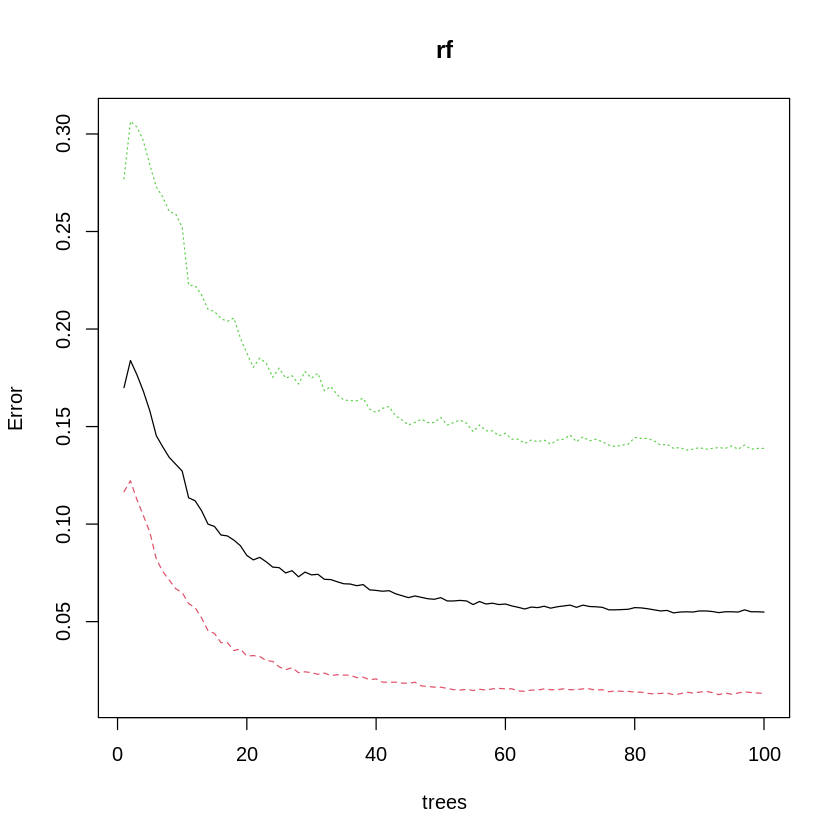

In [9]:
plot(rf)
print(rf)
importance(rf)

## The importance data is big so let's sort it

In [10]:
imp <- as.data.frame(importance(rf))
imp[order(imp$MeanDecreaseAccuracy,decreasing = T),]

,0,1,MeanDecreaseAccuracy,MeanDecreaseGini
,<dbl>,<dbl>,<dbl>,<dbl>
TACG,8.470707,12.26370818,12.886011,161.99705
CTCC,8.449005,8.60661676,10.991181,43.00365
CGAT,8.514848,10.56167698,10.892334,130.10161
CGTA,6.770021,10.94237433,10.878049,134.01042
ACGA,4.159809,9.89953061,9.446693,61.16309
CGAC,6.544312,9.42629219,9.429439,73.41701
TCGA,5.388875,9.52510022,9.417165,96.05929
ATCG,4.305557,9.98011423,9.126993,84.93031
CAGC,6.704761,6.31018814,8.926116,31.42715


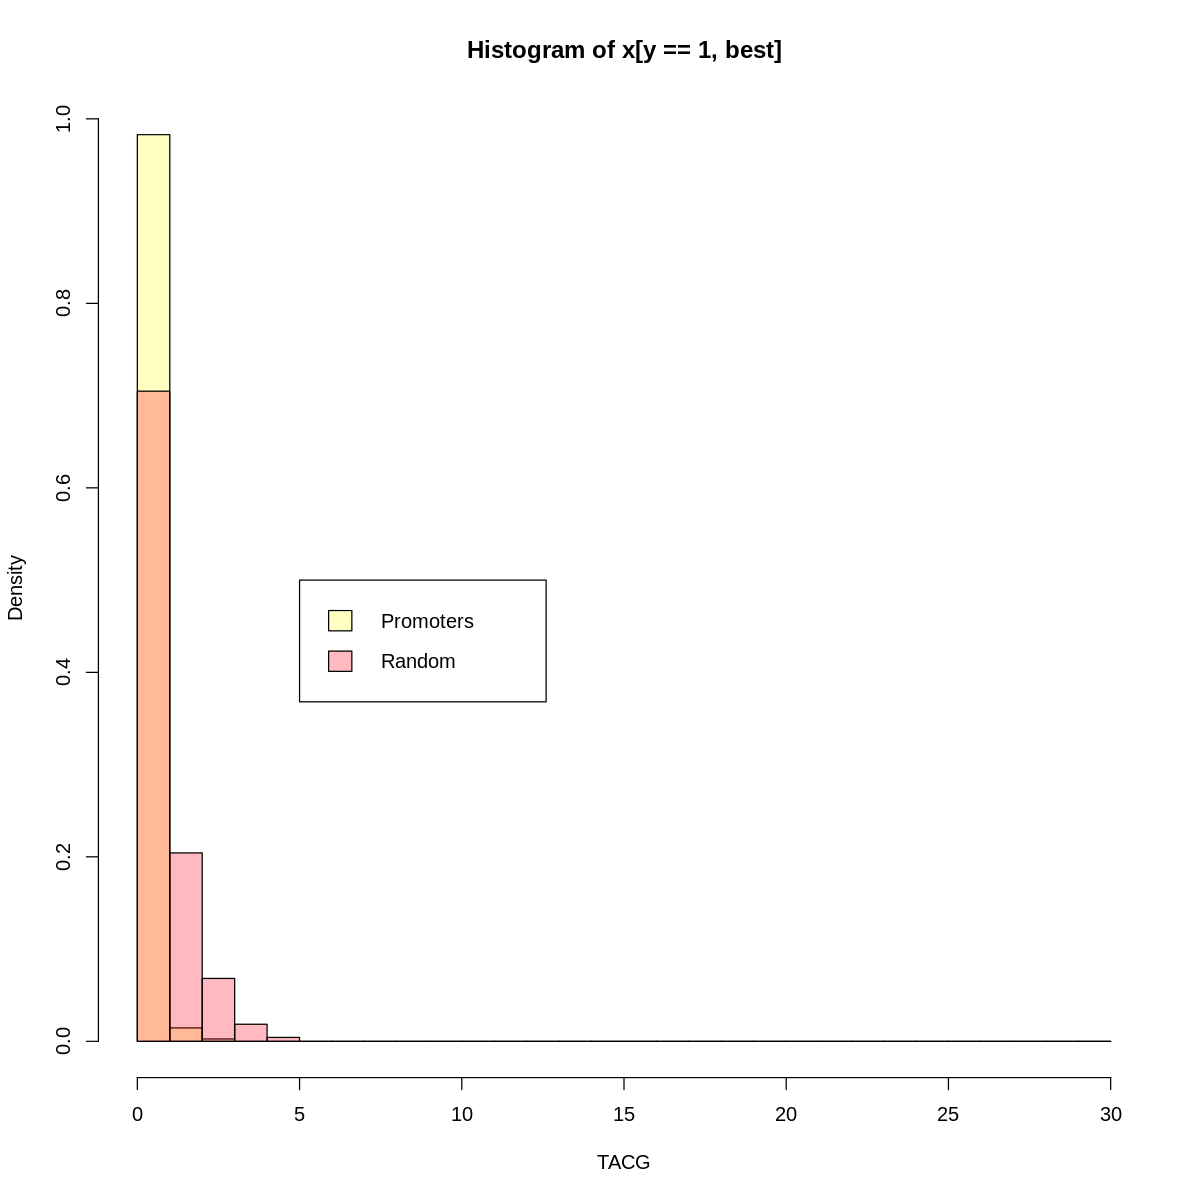

In [11]:

best=which.max(imp$MeanDecreaseAccuracy)
#best=which(rownames(imp)=='TTTT')
name=rownames(imp)[best]


options(repr.plot.width=10,repr.plot.height=10)
ax<-0:30
prom<-hist(x[y==1,best],plot=FALSE,breaks=ax)
rand<-hist(x[y==0,best],plot=FALSE,breaks=ax)

c1=rgb(1,.1,.2,alpha=.30)
c2=rgb(1,1.,.2,alpha=.30)

plot(prom,col=c2,xlab=name,add=F,freq=FALSE)
plot(rand, col=c1,add=T,freq=FALSE)

legend(5,0.5,legend=c('Promoters','Random'),fill=c(c2,c1))




# Exercise try to predict new data
Let's see how well our model works on a new dataset
1. Process the datasets below into kmers
2. Make a histogram comparing the output of this dataset to random sequences


In [12]:
mouse_data<-read.csv("/gpfs/projects/datascience/shared/deePromoter_data/mm_pos_TATA.txt",header=FALSE)


In [13]:
"Your Code Here"

# Create K-mers and predict data
mouse_char<-strsplit(mouse_data[,1],"")
mouse=data.frame(kcount(mouse_char,k=4))
pred<-predict(rf,mouse,type='prob')



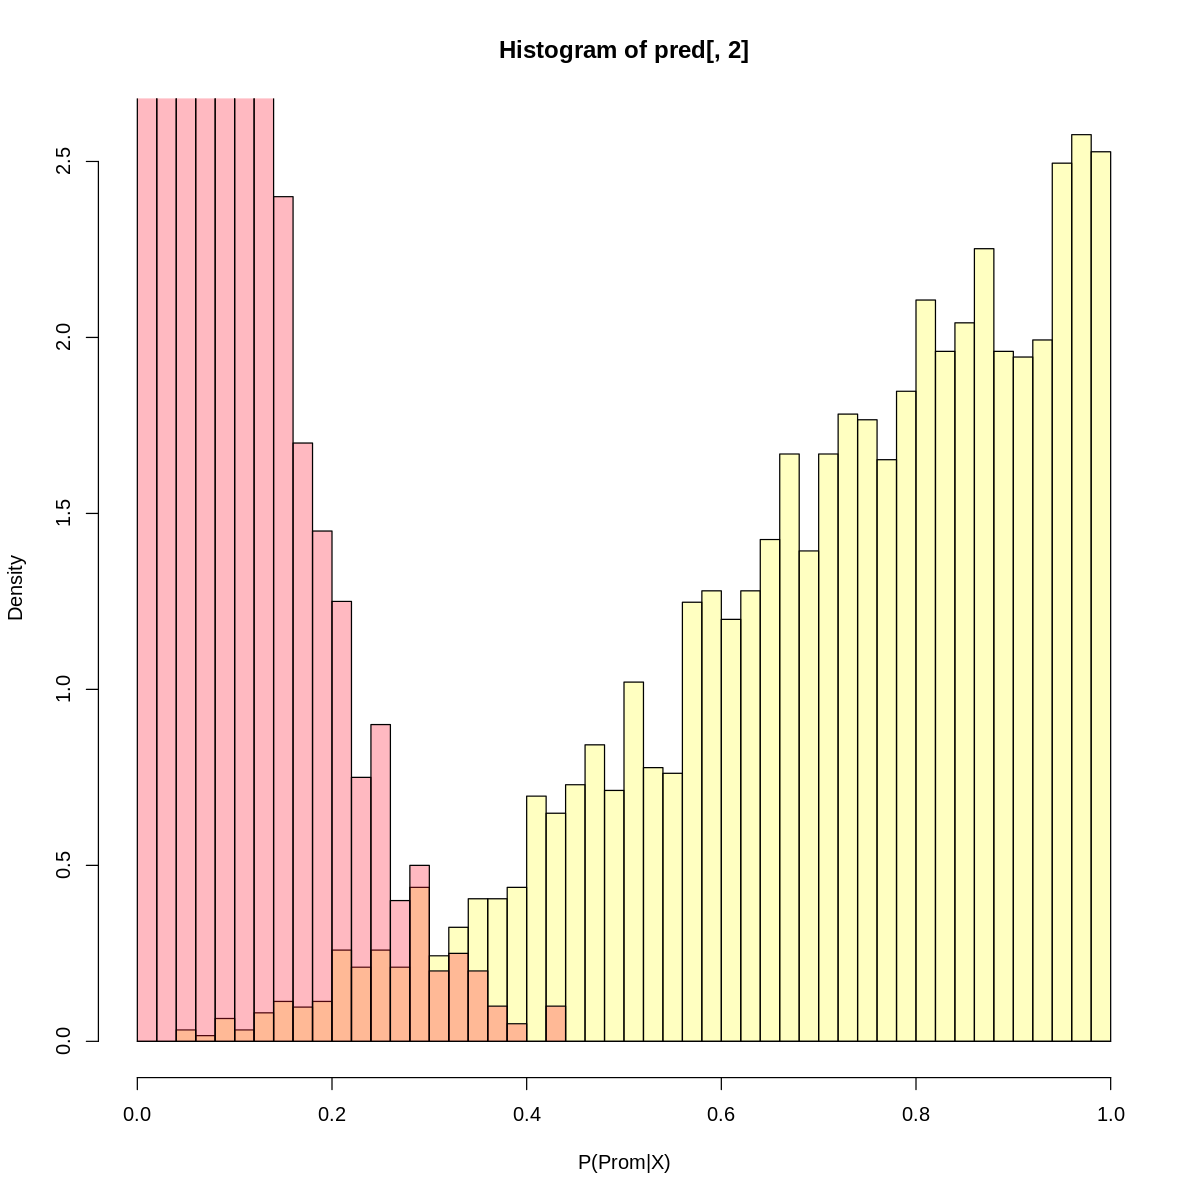

In [14]:

###Generate some fake stuff
rand_pred<-c()
for (i in 1:1000){
    r_sample=sample(c('A','T','G','C'),300,replace=T)
    r_kmer=data.frame(kcount(r_sample,k=4))
    rand_pred<-c(rand_pred,predict(rf,r_kmer,type='prob')[,2])
    }


options(repr.plot.width=10,repr.plot.height=10)
ax<-pretty(0:1,n=50)
prom<-hist(pred[,2],plot=FALSE,breaks=ax)
rand<-hist(rand_pred,plot=FALSE,breaks=ax)

c1=rgb(1,.1,.2,alpha=.30)
c2=rgb(1,1.,.2,alpha=.30)

plot(prom,col=c2,xlab='P(Prom|X)',freq=F)
plot(rand, col=c1,add=TRUE,freq=F)
legend(200,600,legend=c('Promoters','Random'),fill=c(c2,c1))



# Try with a Deep Neural Network

The other way we can look at sequence data is with deep learning. This can be a lot more involve, but sometimes the payoff is worth it.

1. Instead of k-mers we're going to use the sequences mainly as is, however, we need to encode each character with a number. We'll use A=1,T=2,G=3,C=4. 

2. We'll need to write a deep learning model in torch. This can be a creative process with chances to improve your results, we'll use a Convolutional Neural Network or CNN.

3. We'll have to write a training loop, unlike our random forest we'll need to do this ourseleves.


# Convert our Data to Integers

In [15]:
to_int <-function(x){
    out=c()
    for (i in 1:length(x)){
    if (x[i]=='A'){co=1}
    if (x[i]=='T'){co=2}
    if (x[i]=='G'){co=3}
    if (x[i]=='C'){co=4}
    out=c(out,co)
    }
return(out)
}


pos_mat <- do.call("rbind",pos_char)

all_char=rbind(pos_mat,neg_char,rand_char)
head(all_char)

all_char=apply(all_char,2,to_int)
head(all_char)




,C,T,C,C,A,C,T,T,T,T,⋯,C,T,A,C,A,A,G,A,A,C
,C,C,A,G,C,A,G,A,T,G,⋯,A,T,G,A,G,A,A,C,C,C
,T,C,A,G,A,G,A,A,A,C,⋯,T,G,T,G,G,A,A,G,C,C
,G,A,A,A,A,G,G,T,A,A,⋯,C,A,T,C,C,T,A,G,A,A
,C,A,G,G,G,T,C,T,G,C,⋯,C,G,T,C,C,G,T,G,C,T
,A,G,A,A,T,G,A,G,T,G,⋯,A,G,G,G,G,A,A,A,G,G


4,2,4,4,1,4,2,2,2,2,⋯,4,2,1,4,1,1,3,1,1,4
4,4,1,3,4,1,3,1,2,3,⋯,1,2,3,1,3,1,1,4,4,4
2,4,1,3,1,3,1,1,1,4,⋯,2,3,2,3,3,1,1,3,4,4
3,1,1,1,1,3,3,2,1,1,⋯,4,1,2,4,4,2,1,3,1,1
4,1,3,3,3,2,4,2,3,4,⋯,4,3,2,4,4,3,2,3,4,2
1,3,1,1,2,3,1,3,2,3,⋯,1,3,3,3,3,1,1,1,3,3


## Split the data like before

In [16]:
dnn_train <- all_char[train_index,]
dnn_test <- all_char[-train_index,]
#print(nrow(dnn_test))

In [17]:
head(all_char)

4,2,4,4,1,4,2,2,2,2,⋯,4,2,1,4,1,1,3,1,1,4
4,4,1,3,4,1,3,1,2,3,⋯,1,2,3,1,3,1,1,4,4,4
2,4,1,3,1,3,1,1,1,4,⋯,2,3,2,3,3,1,1,3,4,4
3,1,1,1,1,3,3,2,1,1,⋯,4,1,2,4,4,2,1,3,1,1
4,1,3,3,3,2,4,2,3,4,⋯,4,3,2,4,4,3,2,3,4,2
1,3,1,1,2,3,1,3,2,3,⋯,1,3,3,3,3,1,1,1,3,3


# Our DNN Model
There is a flow to most models in torch. 
1. Create your layers

   * **embedding** All text models will start with an 'Embedding' layer which maps each of our input integers into a a continous vector. It's just a learned matrix that returns the row of the each integer you put in
   * Intermediate layers - Convolutions, LSTM, etc
   * An activation function - This is applied at every layer it makes the model non-linear
   * Classification head - Fully connected layer with an outputsize of one

2. Define how they are put together to go from inputs to outputs ( this is called the foward pass)

In [18]:
# Our Deep Neural Network has two functions initializtion and forward

net <- nn_module(
  "CNN model",

  initialize = function(vocab_size,emb_dim,
                        fc1_dim,
                        fc2_dim) {
    self$embedder <- nn_embedding(4,emb_dim)

    self$conv1<- nn_conv1d(emb_dim,50,10,stride=10)
    self$conv2<- nn_conv1d(50,50,10,stride=10)

    self$fc1 <- nn_linear(150, fc1_dim)
    self$fc2 <- nn_linear(fc1_dim, fc2_dim)  
    self$drop <- nn_dropout(0.2)
    self$output <- nn_linear(fc2_dim, 1)
    self$act <- nn_relu()
  },

  forward = function(x) {
    x <- self$embedder(x)

    x <- self$act(self$conv1(x$permute(c(1,3,2))))
    x<-self$drop(x)
    x <- self$act(self$conv2(x))
    x<-self$drop(x)
    x<-torch_flatten(x,start_dim=2)
    x<-self$act(self$fc1(x))
    x<-self$drop(x)
    x<-self$act(self$fc2(x))
    x<-self$drop(x)
    x<-self$output(x)
    x=torch_sigmoid(x)
    x=torch_squeeze(x)
    return(x)
  }
)

model=net(4,4,10,10)

# Batches 
DNN operate one batch at a time. A batch is just a fixed number of examples how many is refered to as the **batch_size**. **batch_sizes** vary from a few to hundreds or thosands 32 is a common default.

**Why Batches**? Computational requirments on DNN are high, normally too high to run an entire dataset at once.



In [19]:


evaluate <- function(X,Y,batch_size){
    x_torch=torch_tensor(X,dtype=torch_int())
    y_torch=torch_tensor(Y,dtype=torch_float())-1 #here labels must be 0 or one but factors convert to 1/2
    dnn_pred=c()
    
    num_batch=floor(nrow(X)/batch_size)
    loss_v=c()
    print('Eval')
    model$eval()
    for (i in 0:num_batch ){
        end = (i+1)*batch_size
        if (end >nrow(X)){
            end=nrow(X)
            }
        batch_i=torch_tensor((i*batch_size+1):end)
        batch=x_torch[batch_i,]
        output=torch_squeeze(model(batch))
        loss <- criterion(output,y_torch[batch_i]) 
        loss_v=c(loss_v,c(loss$item()))
        dnn_pred<-c(dnn_pred,as.array(output))
        flush.console()    
    }
    model$train()
    
    return( list(pred=dnn_pred,loss=loss_v))
    }



In [20]:
optimizer <- optim_adam(model$parameters,lr=1e-3)
criterion <- nn_bce_loss()

In [21]:
batch_size <- 10
num_epochs <- 4


num_data_points <- length(y)
num_batches <- floor(num_data_points/batch_size)


for(current_epoch in 1:num_epochs){
  permute <- sample(num_data_points)
  data_x <- torch_tensor(dnn_train[permute,],dtype=torch_int())
  data_y <- torch_tensor(y[permute],,dtype=torch_float())-1
  
  running_loss=c()
  for(batch_idx in 1:num_batches){
    batch_i <- (batch_size*(batch_idx-1) + 1):(batch_idx*batch_size)
    batch=data_x[batch_i,]
    optimizer$zero_grad()
    output <- model(batch)
    loss <- criterion(output, data_y[batch_i]) #here labels must be 0 or one but factors convert to 1/2
    loss$backward()
    optimizer$step()

    running_loss=c(running_loss,c(loss$item()))
      
    if (length(running_loss)==50) {
        cat("train_loss",mean(running_loss), "epoch",current_epoch,"batch",batch_idx,"\n")
        running_loss=c()
        flush.console()
        }
    }
  ev_vals=evaluate(dnn_test,ytest,10)
  cat("Validation Loss",mean(ev_vals$loss),"Epoch",current_epoch,"\n")
      
  
}

train_loss 0.6580604 epoch 1 batch 50 
train_loss 0.6073351 epoch 1 batch 100 
train_loss 0.5326975 epoch 1 batch 150 
train_loss 0.4655676 epoch 1 batch 200 
train_loss 0.3432708 epoch 1 batch 250 
train_loss 0.2678364 epoch 1 batch 300 
train_loss 0.2816961 epoch 1 batch 350 
train_loss 0.2587819 epoch 1 batch 400 
train_loss 0.2332497 epoch 1 batch 450 
train_loss 0.1943911 epoch 1 batch 500 
train_loss 0.2114067 epoch 1 batch 550 
train_loss 0.2023194 epoch 1 batch 600 
train_loss 0.2013079 epoch 1 batch 650 
train_loss 0.2001478 epoch 1 batch 700 
[1] "Eval"
Validation Loss 0.159796 Epoch 1 
train_loss 0.1905613 epoch 2 batch 50 
train_loss 0.1479841 epoch 2 batch 100 
train_loss 0.1681443 epoch 2 batch 150 
train_loss 0.2358984 epoch 2 batch 200 
train_loss 0.1678595 epoch 2 batch 250 
train_loss 0.1597163 epoch 2 batch 300 
train_loss 0.143394 epoch 2 batch 350 
train_loss 0.1532218 epoch 2 batch 400 
train_loss 0.1259741 epoch 2 batch 450 
train_loss 0.1434139 epoch 2 batch 500

In [22]:
model$eval

function () 
{
    self$train(FALSE)
}
<environment: 0x55555f28dc00>

In [23]:
torch_save(model$state_dict(), 'model.pth')

In [24]:
#model$load_state_dict(torch_load('/projects/datascience/shared/DATA4ML_weights/model.pth'))

In [25]:
ev_vals=evaluate(dnn_test,ytest,10)
dnn_pred=ev_vals[[1]]


[1] "Eval"


In [26]:
sum(((dnn_pred>0.5) == (ytest==1)))/length(ytest)

[1] 0.9590444

In [27]:
sum(dnn_pred[ytest==1]>0.5)/sum(ytest==1)

[1] 0.9210084

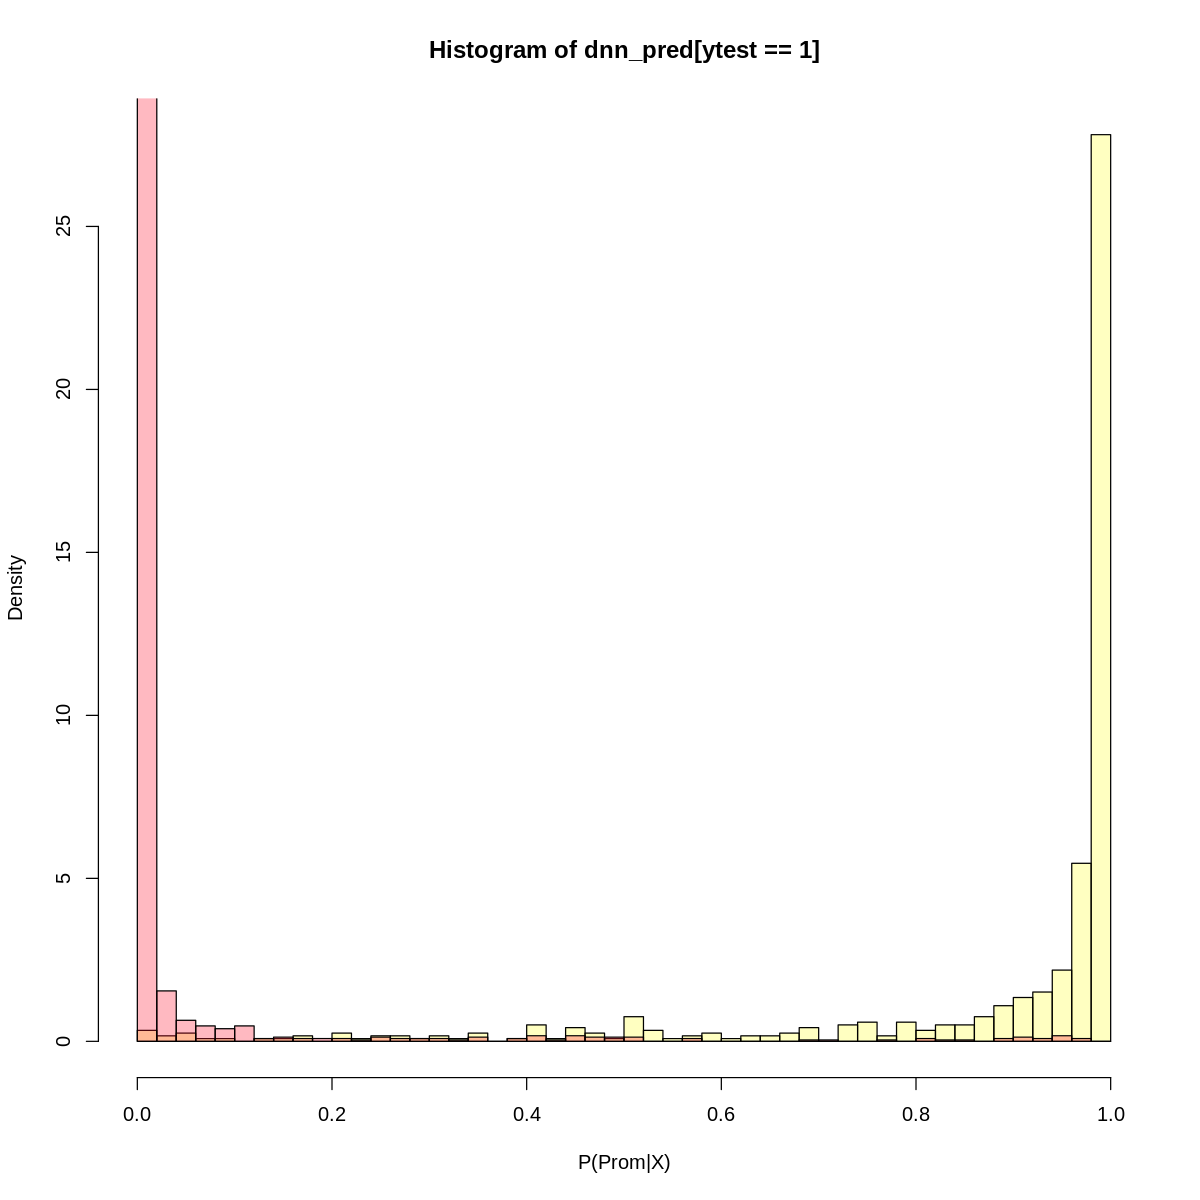

In [28]:

options(repr.plot.width=10,repr.plot.height=10)
ax<-pretty(0:1,n=50)
prom<-hist(dnn_pred[ytest==1],plot=FALSE,breaks=ax)
rand<-hist(dnn_pred[ytest==0],plot=FALSE,breaks=ax)

c1=rgb(1,.1,.2,alpha=.30)
c2=rgb(1,1.,.2,alpha=.30)

plot(prom,col=c2,xlab='P(Prom|X)',freq=F)
plot(rand, col=c1,add=TRUE,freq=F)
legend(200,600,legend=c('Promoters','Random'),fill=c(c2,c1))



# Exercise 
Try our DNN on Mouse Data

In [29]:
"Your Code Here"

mouse_char<-strsplit(mouse_data[,1],"")
mouse_mat <- do.call("rbind",mouse_char)


mouse_int<-apply(mouse_mat,2,to_int)
nrow(mouse_int)

ev_vals=evaluate(mouse_int,rep(1,nrow(mouse_int)),10)

mouse_pred=ev_vals$pred


[1] 3086

[1] "Eval"


[1] 3086

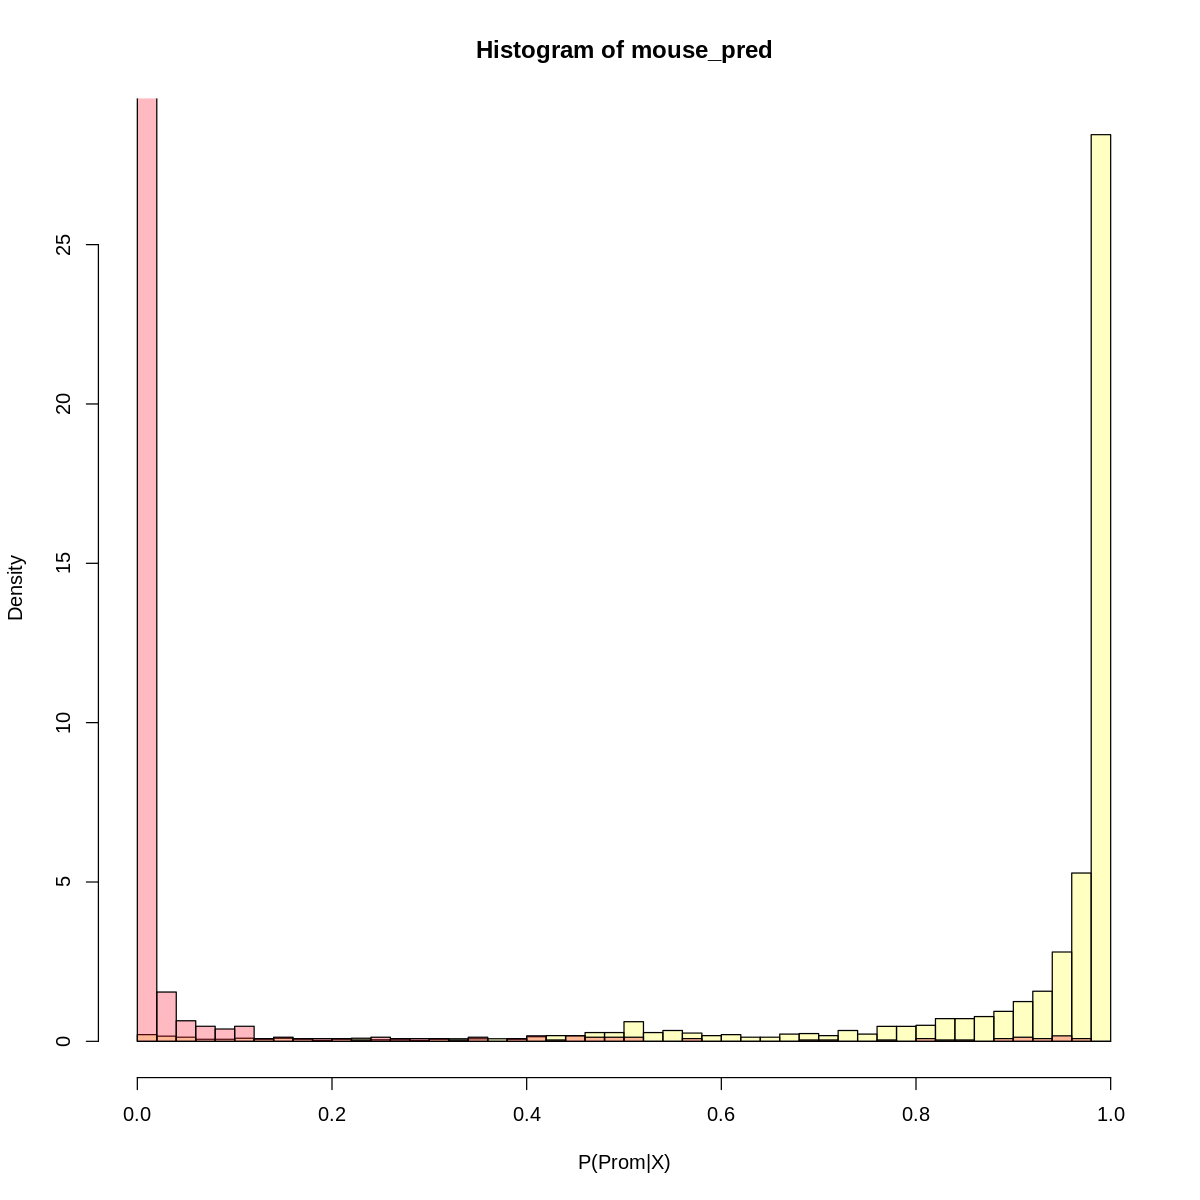

In [30]:

options(repr.plot.width=10,repr.plot.height=10)
ax<-pretty(0:1,n=50)
prom<-hist(mouse_pred,plot=FALSE,breaks=ax)
rand<-hist(dnn_pred[ytest==0],plot=FALSE,breaks=ax)

c1=rgb(1,.1,.2,alpha=.30)
c2=rgb(1,1.,.2,alpha=.30)

plot(prom,col=c2,xlab='P(Prom|X)',freq=F)
plot(rand, col=c1,add=TRUE,freq=F)
legend(200,600,legend=c('Promoters','Random'),fill=c(c2,c1))
